In [1]:
import Modules.SQcircuit_extensions as sq_ext
import SQcircuit as sq
import qutip as qt
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import importlib

%matplotlib ipympl

importlib.reload(sq_ext)
importlib.reload(sq)
np.set_printoptions(linewidth=500, formatter={'float': '{:.1e}'.format})

# Single circuit

This notebook studies the circuit proposed by KIT. It's lumped element model is:
<img src='Other/Two qubits - antisymmetric C coupling.jpg' width='500'>


## Define the circuit

In [2]:
# Fundamental constants
h    = 6.626e-34
GHz = 1e9
e0   = 1.602e-19
Φ_0 = h/(2*e0)

# Circuit parameters
Csh = 15
C   = 15
Cg  = 10
CJ  = 3
Lq  = 25
Lr  = 10
Δ   = 0.1
EJ  = 10.0
l = Lq*(Lq+4*Lr) - 4*Δ**2

Cc = 15

# Initialize loop(s)
loop1 = sq.Loop(0.0)
loop2 = sq.Loop(0.0)

# Circuit components
C_01, C_02, C_12, L_03, L_31, L_23, JJ_12 = [[] for _ in range(7)]
for loop in [loop1, loop2]:
    C_01 .append(sq.Capacitor(C,       'fF'))
    C_02 .append(sq.Capacitor(C,       'fF'))
    C_12 .append(sq.Capacitor(CJ+Csh,  'fF'))
    L_03 .append(sq.Inductor(Lr,       'nH'))
    L_31 .append(sq.Inductor(Lq/2 - Δ, 'nH',  loops=[loop]))
    L_23 .append(sq.Inductor(Lq/2 + Δ, 'nH',  loops=[loop]))
    JJ_12.append(sq.Junction(EJ,       'GHz', loops=[loop]))

C_24 = sq.Capacitor(Cc, 'fF')

# Define the circuit
elements = {
    # qubit 1, nodes [0, 1, 2, 3]
    (0, 3): [L_03[0]],
    (0, 1): [C_01[0]],
    (0, 2): [C_02[0]],
    (3, 1): [L_31[0]],
    (1, 2): [C_12[0], JJ_12[0]],
    (2, 3): [L_23[0]],
    # qubit 2, nodes [0, 4, 5, 6]
    (0, 6): [L_03[1]],
    (0, 4): [C_01[1]],
    (0, 5): [C_02[1]],
    (6, 4): [L_31[1]],
    (4, 5): [C_12[1], JJ_12[1]],
    (5, 6): [L_23[1]],
    # capacitive coupling
    (2, 4): [C_24]
}

# Create the circuits
circuit = sq.Circuit(elements)
circuit.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [3]:
circuit.S

array([[1.6e+01, -2.2e+00, 5.1e+01, 1.1e+00, -4.5e-01, -5.2e-01],
       [1.7e+01, -1.6e+00, 5.0e+01, 8.1e-02, 4.8e-01, -1.5e+00],
       [3.3e+08, -6.4e+07, 3.1e+01, 3.6e-01, 7.5e-03, -6.3e-01],
       [1.7e+01, 1.2e+00, 5.0e+01, -1.7e-01, 4.8e-01, 1.5e+00],
       [1.8e+01, 2.2e+00, 4.9e+01, -1.1e+00, -5.2e-01, 5.2e-01],
       [3.5e+08, 6.1e+07, 3.0e+01, -3.8e-01, -8.0e-03, 6.2e-01]])

In [4]:
[ print(f'Mode {i+1} = {circuit.S[:,i]}') for i in range(circuit.S.shape[1]) ]

Mode 1 = [1.6e+01 1.7e+01 3.3e+08 1.7e+01 1.8e+01 3.5e+08]
Mode 2 = [-2.2e+00 -1.6e+00 -6.4e+07 1.2e+00 2.2e+00 6.1e+07]
Mode 3 = [5.1e+01 5.0e+01 3.1e+01 5.0e+01 4.9e+01 3.0e+01]
Mode 4 = [1.1e+00 8.1e-02 3.6e-01 -1.7e-01 -1.1e+00 -3.8e-01]
Mode 5 = [-4.5e-01 4.8e-01 7.5e-03 4.8e-01 -5.2e-01 -8.0e-03]
Mode 6 = [-5.2e-01 -1.5e+00 -6.3e-01 1.5e+00 5.2e-01 6.2e-01]


[None, None, None, None, None, None]

# Equivalent circuits

In [5]:
loop_eq = sq.Loop(0.0)
equiv_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor ( 1/(  1/(l/Lq) -  1/(l/Δ)  ), 'nH')],
    # (1, 2): [sq.Capacitor (l/Δ, 'fF')],
    (1, 2): [sq.Inductor (l/Δ, 'nH')],
    (0, 2): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor ( 1/(  1/(l/(Lq+4*Lr)) -  1/(l/Δ)  ), 'nH',  loops=[loop_eq]), sq.Junction (EJ, 'GHz', loops=[loop_eq])],
}
circ_equiv = sq.Circuit(equiv_elements )
circ_equiv.description()

LinAlgError: Last 2 dimensions of the array must be square

In [6]:
resonator_elements = {
    (0, 1): [sq.Capacitor(C/2, 'fF'), sq.Inductor (l/Lq, 'nH')],
}
resonator = sq.Circuit(resonator_elements )
resonator.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [7]:
loop_fluxonium = sq.Loop(0.0)
fluxonium_elements = {
    (0, 1): [sq.Capacitor(C/2 + Csh + CJ, 'fF'), sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium])],
    # (0, 1): [sq.Inductor(l/(Lq+4*Lr), 'nH', loops=[loop_fluxonium]), sq.Junction(EJ, 'GHz', loops=[loop_fluxonium], cap=sq.Capacitor(C/2 + Csh + CJ, 'fF'))],
}
fluxonium = sq.Circuit(fluxonium_elements)
fluxonium.description()

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

# Spectrum


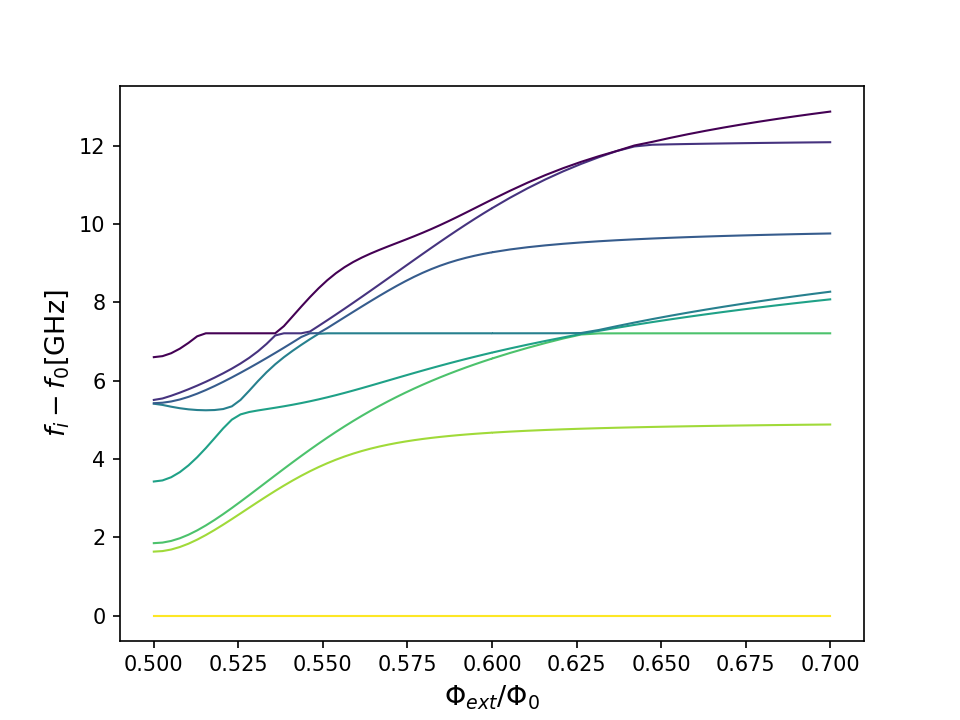

In [15]:
circuit.set_trunc_nums([1, 1, 5, 10, 10, 10])

# spectrum of the circ_equiv
phi = np.concatenate( (np.linspace(0.5, 0.6, 40), np.linspace(0.6,0.7,20)) )
# phi = np.linspace(0.36,0.38,500)
n_eig=8
spec = np.zeros((n_eig, len(phi)))

eig_colors = plt.get_cmap('viridis_r')(np.linspace(0, 255, n_eig).astype('int'))
for i in range(len(phi)):
    # set the external flux for the loop
    loop1.set_flux(phi[i])
    loop2.set_flux(phi[i])
    # diagonalize the circ_equiv
    spec[:, i] = circuit.diag(n_eig)[0]

fig, ax = plt.subplots(dpi=150)
for i in range(n_eig):
    ax.plot(phi, spec[i,:]- spec[0,:], color=eig_colors[i], linewidth=1)

ax.set_xlabel(r"$\Phi_{ext}/\Phi_0$", fontsize=13)
ax.set_ylabel(r"$f_i-f_0$[GHz]", fontsize=13)
# ax.set_ylim(7,7.5)
fig.show()

# Fluxonium-Resonator internal coupling in KIT's qubit

In [67]:
fluxonium.set_trunc_nums([15])
resonator.set_trunc_nums([15])
loop_fluxonium.set_flux(0.5)
loop.set_flux(0.5)
_ = circuit.diag(2)
_ = fluxonium.diag(2)
_ = resonator.diag(2)

In [68]:
Δ01 = (circuit.efreqs[1]-circuit.efreqs[0])
Δ01

1.945236802342495

In [69]:
L_c = l / Δ * 1e-9
E_L_c = (Φ_0/(2*np.pi))**2/L_c / h / GHz
E_L_c

0.01006152950650398

In [86]:
f=fluxonium.flux_op(0, basis='eig')

In [70]:
Φ_f = sq_ext.decomposition_in_pauli_2x2(fluxonium.flux_op(0, basis='eig').__array__())[1]
Φ_f

38.41921243891213

In [71]:
Φ_r = sq_ext.decomposition_in_pauli_2x2(resonator.flux_op(0, basis='eig').__array__())[1]
Φ_r

38.365883888557015

In [72]:
g = Φ_r * Φ_f / L_c / GHz
g

0.0907091278259839

In [73]:
g / Δ01 * 100

4.66314063751776

### Analytical approximation of the fluxonim-resonator coupling

In [74]:
dVdφ =  lambda φ: E_L_f*φ + E_J*np.sin(φ+np.pi)
φ_min = sp.optimize.fsolve(dVdφ, 1)[0]
φ_min

1.527628932582084

In [80]:
Φ_f_an =(Φ_0 / 2*np.pi) * φ_min
Φ_f_an

483.2352418014397

In [81]:
Φ_r_an = np.sqrt(sq.hbar/2 * np.sqrt(L_r/C_r))
Φ_r_an

38.36589667717856

In [83]:
g_an = Φ_f_an * Φ_r_an /L_c / h /GHz
g_an

1.1409359835150057

In [84]:
g_an / Δ01 * 100

58.652806801776855